Restarted base (Python 3.11.5)

In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 18 15:48:34 2023

@author: coenberns
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import datetime, timedelta, time
import pathlib 
from Plot_EGG import*
import timeit
import time
import cProfile
import sklearn
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import UnivariateSpline as univsp
from scipy.signal import savgol_filter
from compaction_read_burst import*

In [3]:
groupdat_3 = groupdats['function3']

n_burst=5
sleep_ping=1

groupdat_3['avg_groups'] = (groupdat_3['packet_miss_idx']/(n_burst+sleep_ping)).apply(np.floor)

for i in range(8):
    channel = f'Channel {i}'
    new_channel = f'Channel_avg {i}'
    # Calculate mean and store in new Channel_avg columns, overwriting old data
    groupdat_3[new_channel] = groupdat_3.groupby('avg_groups')[channel].transform(lambda x: x.mean(skipna=True))

In [4]:
groupdat_3_newmean = groupdat_3[groupdat_3['packet_miss_idx'] % (n_burst+sleep_ping) == 0]
for i in range(8):
    channel = f'Channel_avg {i}'
    new_channel = f'Channel_intp {i}'
    groupdat_3_newmean[new_channel] = groupdat_3_newmean[channel].interpolate(method='cubic')


C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25228\4030028707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupdat_3_newmean[new_channel] = groupdat_3_newmean[channel].interpolate(method='cubic')
C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25228\4030028707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupdat_3_newmean[new_channel] = groupdat_3_newmean[channel].interpolate(method='cubic')
C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25228\4030028707.py:5: SettingWithCopyWarning: 
A 

In [21]:
groupdat_3_oldmean = groupdats_mean['function3']
for i in range(8):
    channel = f'Channel {i}'
    new_channel = f'Channel_intp {i}'
    groupdat_3_oldmean[new_channel] = groupdat_3_oldmean[channel].interpolate(method='cubic')


In [22]:
# Calculating percentages of na rows to compare the two. For an initial try, the difference
# in percentage is new 23.241156542976444 compared to 41.5268258095013 for firstpart ambu
num_rows_na_mean_new = groupdat_3_newmean['Channel_avg 3'].isna().sum()
perc_na_mean_new = (num_rows_na_mean_new/ len(groupdat_3_newmean)) * 100

num_rows_na_mean_old = groupdat_3_oldmean['Channel 0'].isna().sum()
perc_na_mean_old = (num_rows_na_mean_old/ len(groupdat_3_oldmean)) * 100

print(perc_na_mean_new, perc_na_mean_old)

23.241156542976444 0.007878358150161507


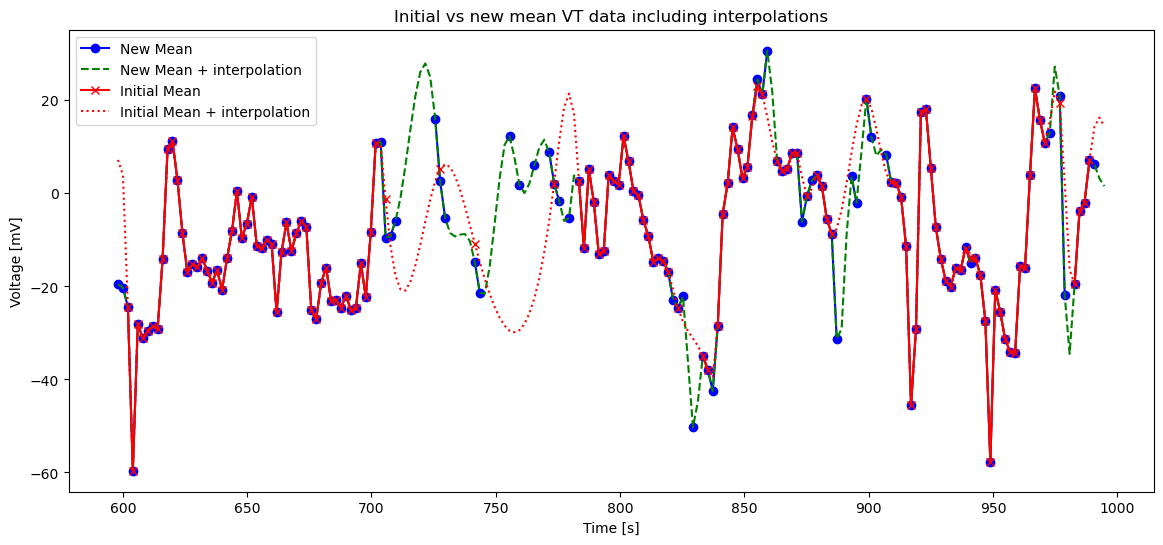

In [7]:
new_mean = groupdat_3_newmean[300:500]
x = new_mean['corrected_t_f3']
old_mean = groupdat_3_oldmean[300:500]
x2 = old_mean['corrected_t_f3']

plt.figure(figsize=(14, 6))
plt.plot(x, new_mean['Channel_avg 5'], marker='o', label='New Mean', color = 'b')
plt.plot(x, new_mean['Channel_intp 5'], label='New Mean + interpolation', color = 'g', linestyle = 'dashed')
plt.plot(x2, old_mean['Channel 5'], label='Initial Mean', marker = 'x', color = 'r')
plt.plot(x2, old_mean['Channel_intp 5'], label='Initial Mean + interpolation', color = 'r', linestyle = ':')
# plt.plot(smalldat['timestamps'], smalldat['Channel_interp_savgol5'], label='Interpolated + Savgol', linestyle='dashdot')
plt.title('Initial vs new mean VT data including interpolations')
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [8]:
overwrite_newmean = groupdat_3_newmean
for i in range(8):
    channel = f'Channel {i}'
    new_channel = f'Channel_intp {i}'
    overwrite_newmean[channel] = overwrite_newmean[new_channel]
overwrite_newmean['timestamps'] = overwrite_newmean['corrected_t_f3']
datcols = ['timestamps'] + [f'Channel {i}' for i in range(8)]
final_newmean = overwrite_newmean[datcols]

C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25228\3902151930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overwrite_newmean[channel] = overwrite_newmean[new_channel]
C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25228\3902151930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overwrite_newmean['timestamps'] = overwrite_newmean['corrected_t_f3']


(<Figure size 1000x2000 with 8 Axes>,
 array([<Axes: ylabel='Channel 7'>, <Axes: ylabel='Channel 6'>,
        <Axes: ylabel='Channel 5'>, <Axes: ylabel='Channel 4'>,
        <Axes: ylabel='Channel 3'>, <Axes: ylabel='Channel 2'>,
        <Axes: ylabel='Channel 1'>,
        <Axes: xlabel='Frequency (1/mins)', ylabel='Channel 0'>],
       dtype=object),
 array([[0.00000000e+00, 2.37133284e-03, 4.74266569e-03, ...,
         1.50437356e+01, 1.50461069e+01, 1.50484782e+01],
        [2.69607777e-26, 1.48955829e+05, 2.19704682e+05, ...,
         1.07981731e+01, 1.37587993e+01, 1.37212060e+01],
        [1.47971500e-27, 7.92538432e+04, 1.38833550e+05, ...,
         5.81933150e+00, 2.57613114e+00, 9.30700192e-01],
        ...,
        [5.70167273e-27, 2.66801269e+06, 7.16398135e+06, ...,
         1.31880217e+01, 1.15615563e+01, 1.65040375e+01],
        [5.59460145e-29, 5.05039926e+06, 1.20000942e+05, ...,
         2.01236070e+01, 1.45083677e+01, 1.79896495e+01],
        [6.73270640e-26, 1.274411

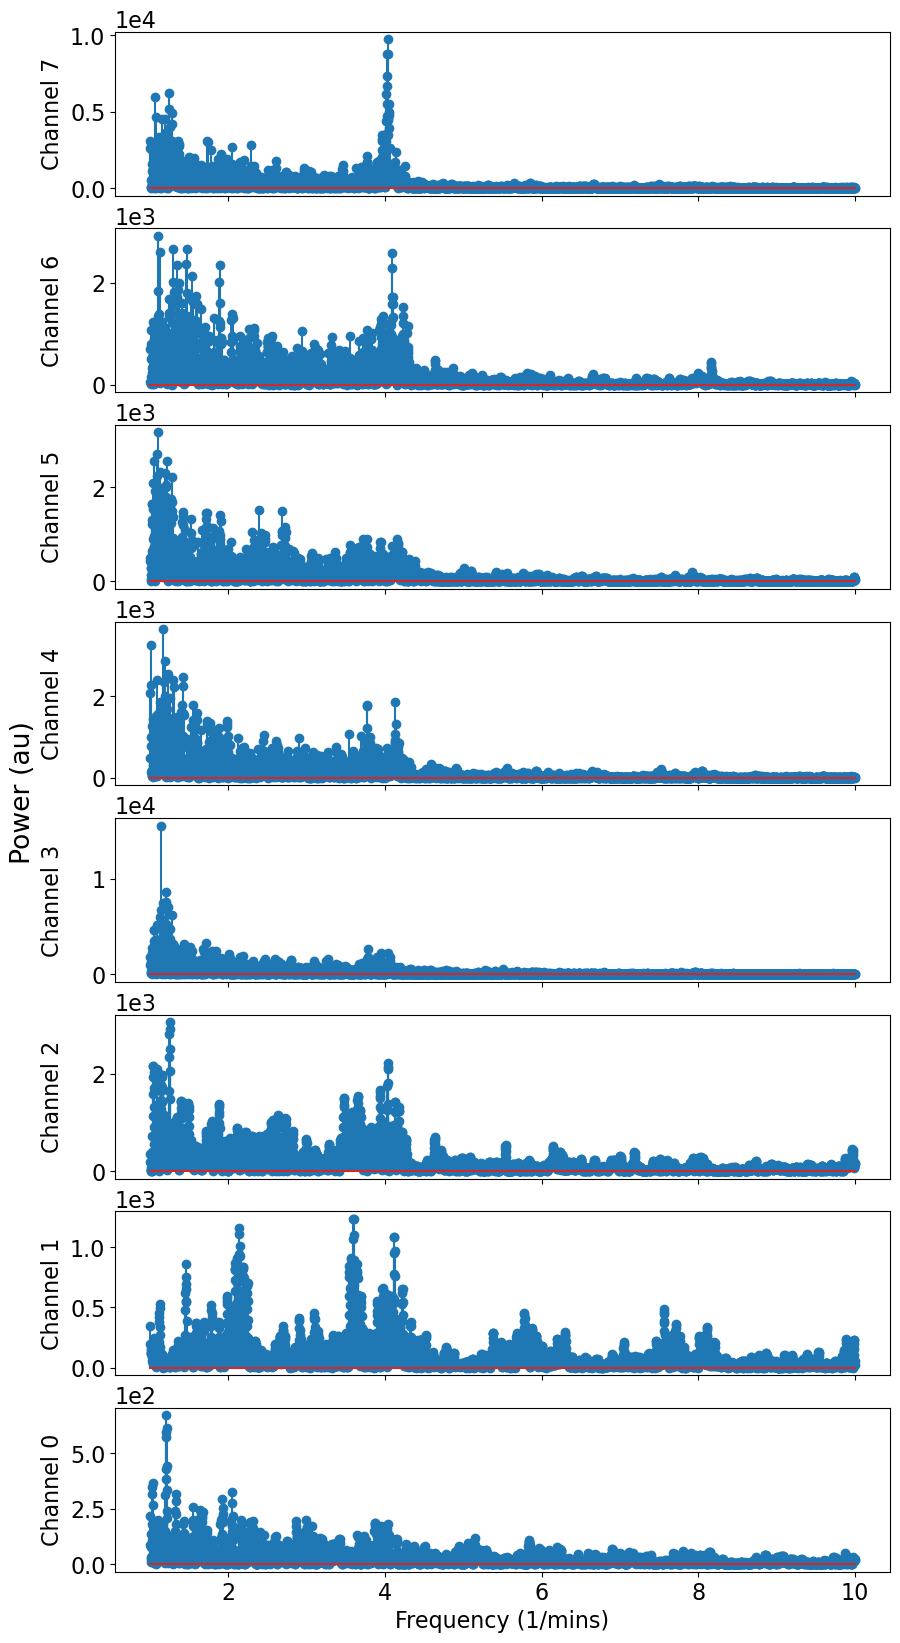

In [32]:
egg_signalfreq(final_newmean, rate=1/1.9934,freqlim=[1,10],mode='power')

In [23]:
overwrite_oldmean = groupdat_3_oldmean
for i in range(8):
    channel = f'Channel {i}'
    new_channel = f'Channel_intp {i}'
    overwrite_oldmean[channel] = overwrite_oldmean[new_channel]
overwrite_oldmean['timestamps'] = overwrite_oldmean['corrected_t_f3']
datcols = ['timestamps'] + [f'Channel {i}' for i in range(8)]
final_oldmean = overwrite_oldmean[datcols]
final_oldmean = final_oldmean.dropna()

(<Figure size 1000x2000 with 8 Axes>,
 array([<Axes: ylabel='Channel 7'>, <Axes: ylabel='Channel 6'>,
        <Axes: ylabel='Channel 5'>, <Axes: ylabel='Channel 4'>,
        <Axes: ylabel='Channel 3'>, <Axes: ylabel='Channel 2'>,
        <Axes: ylabel='Channel 1'>,
        <Axes: xlabel='Frequency (1/mins)', ylabel='Channel 0'>],
       dtype=object),
 array([[0.00000000e+00, 2.37151968e-03, 4.74303936e-03, ...,
         1.50449209e+01, 1.50472924e+01, 1.50496639e+01],
        [4.92425885e-26, 1.17491771e+05, 1.63259320e+05, ...,
         9.75484715e+00, 1.35983850e+01, 5.34403559e+00],
        [6.35513143e-26, 5.24752576e+04, 6.91791190e+04, ...,
         2.46415226e+00, 1.25439676e+00, 1.84977851e-01],
        ...,
        [5.94676234e-27, 9.55277909e+05, 5.58045517e+06, ...,
         6.21610008e+00, 6.14063496e+00, 4.91423552e+00],
        [1.09029640e-24, 3.87852100e+06, 1.68976969e+04, ...,
         1.26736102e+01, 8.40403884e+00, 7.33012520e+00],
        [1.64425731e-28, 1.804621

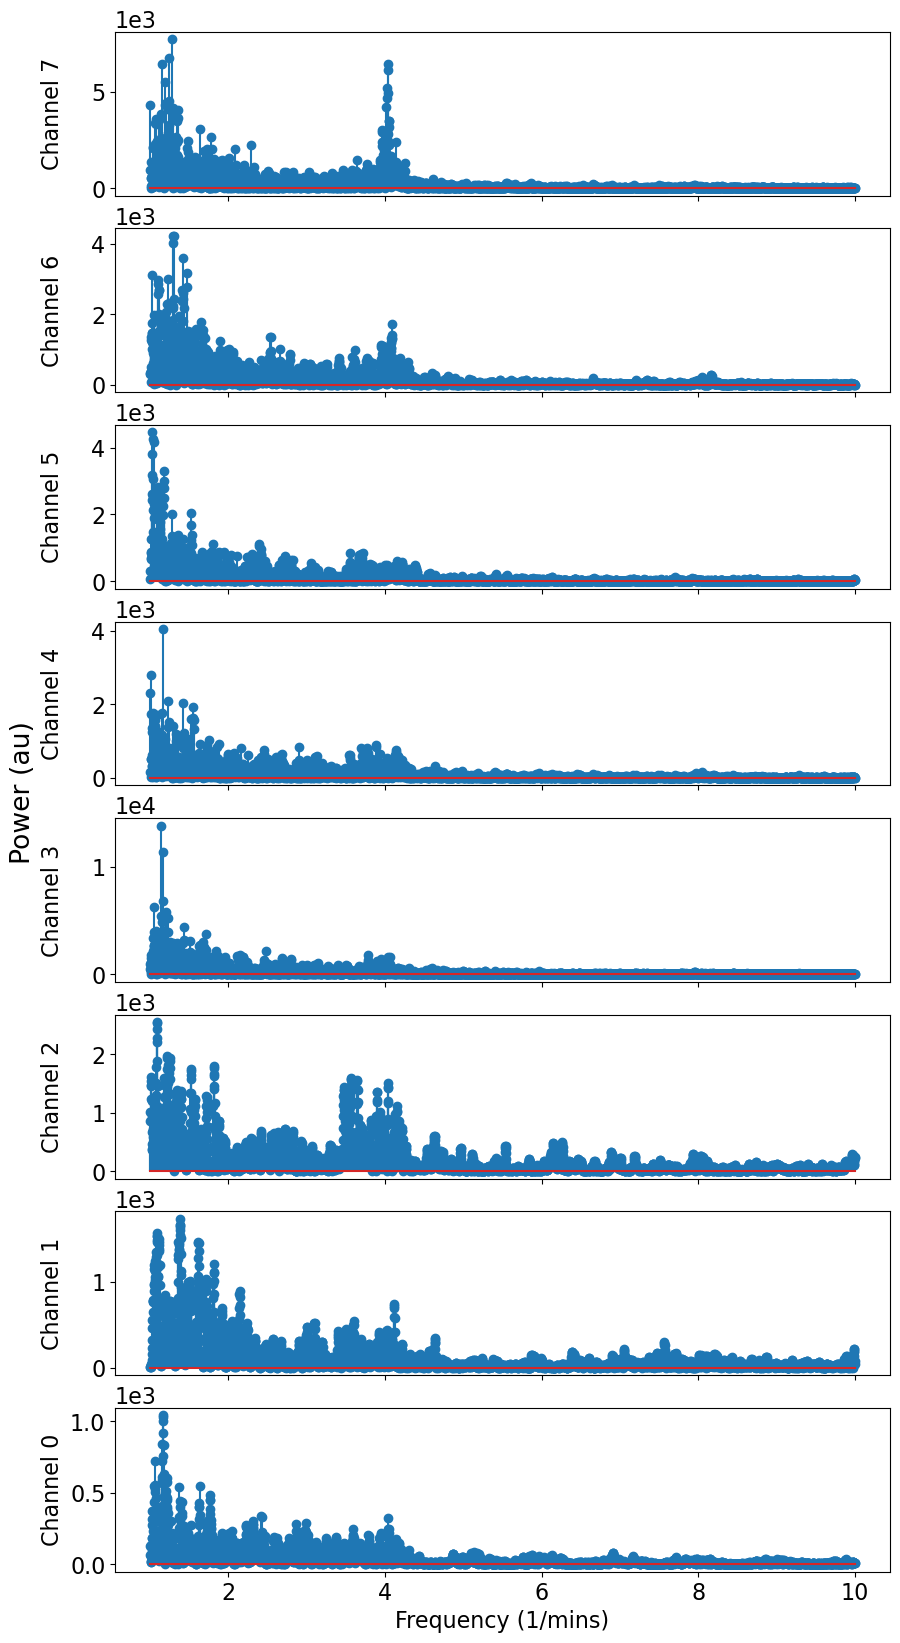

In [34]:
egg_signalfreq(final_oldmean, rate=1/1.9934, freqlim=[1,10],mode='power')

In [45]:
#egg_freq_heatplot_v2(final_newmean, rate=1/1.9934, time ='timestamps')

food_final_day1 = final_newmean[5995:9000]
food_final_day1['timestamps']=food_final_day1['timestamps']-\
    food_final_day1['timestamps'].iloc[0]

egg_freq_heatplot_v2(food_final_day1, rate=1/1.9934, time ='timestamps', xlim=[0,4000], freqlim=[1,6], seg_length=400)

C:\Users\CoenBerns\AppData\Local\Temp\ipykernel_25228\4159671571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_final_day1['timestamps']=food_final_day1['timestamps']-\


[0, 400]
[40.0, 440.0]
[80.0, 480.0]
[120.0, 520.0]
[160.0, 560.0]
[200.0, 600.0]
[240.0, 640.0]
[280.0, 680.0]
[320.0, 720.0]
[360.0, 760.0]
[400.0, 800.0]
[440.0, 840.0]
[480.0, 880.0]
[520.0, 920.0]
[560.0, 960.0]
[600.0, 1000.0]
[640.0, 1040.0]
[680.0, 1080.0]
[720.0, 1120.0]
[760.0, 1160.0]
[800.0, 1200.0]
[840.0, 1240.0]
[880.0, 1280.0]
[920.0, 1320.0]
[960.0, 1360.0]
[1000.0, 1400.0]
[1040.0, 1440.0]
[1080.0, 1480.0]
[1120.0, 1520.0]
[1160.0, 1560.0]
[1200.0, 1600.0]
[1240.0, 1640.0]
[1280.0, 1680.0]
[1320.0, 1720.0]
[1360.0, 1760.0]
[1400.0, 1800.0]
[1440.0, 1840.0]
[1480.0, 1880.0]
[1520.0, 1920.0]
[1560.0, 1960.0]
[1600.0, 2000.0]
[1640.0, 2040.0]
[1680.0, 2080.0]
[1720.0, 2120.0]
[1760.0, 2160.0]
[1800.0, 2200.0]
[1840.0, 2240.0]
[1880.0, 2280.0]
[1920.0, 2320.0]
[1960.0, 2360.0]
[2000.0, 2400.0]
[2040.0, 2440.0]
[2080.0, 2480.0]
[2120.0, 2520.0]
[2160.0, 2560.0]
[2200.0, 2600.0]
[2240.0, 2640.0]
[2280.0, 2680.0]
[2320.0, 2720.0]
[2360.0, 2760.0]
[2400.0, 2800.0]
[2440.0, 28

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 33 and the array at index 1 has size 34